Intro blurb

#http://pygments.org/demo/

In [1]:
#!pip install --user --upgrade pip
import pandas as pd

#!pip install --user matplotlib-venn
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles
from matplotlib_venn import venn3, venn3_circles
plt.style.use('tableau-colorblind10')

Start of importing our dataset. the last two columns set to strings, not necessary, but improves visualls in this notebook.

In [40]:
codeSet = pd.read_table('SCT_HDA_2019_Dataset.txt',dtype={'Condition':str,'Medication':str})
#we don't need First and Last Name
codeSet.drop(["First", "Last"], axis=1,inplace=True)

print(codeSet.head(10))
print(codeSet.tail(5))
print('\n')

print('Number of unique Condition codes :'+str(codeSet['Condition'].nunique()))
print('Number of unique Medication codes :'+str(codeSet['Medication'].nunique()))


  Sex         DoB PostCode  Condition          Medication
0   F  26/04/1998      B03  102930000    7086011000036102
1   F  24/01/1953      E00   49512000    1112071000168105
2   M   7/09/1943      E00  277627005    5604011000036100
3   M   1/01/1966      E00    3109008       3231000036108
4   F  14/02/1957      E00  723409007    6286011000036105
5   M  14/08/1961      E00    3272007     761951000168100
6   F  28/01/1986      C04   86225009  921045011000036104
7   F  15/06/1983      C04  163577001                 NaN
8   F  23/05/1967      C04  191737008  927853011000036101
9   F  29/01/1983      C04  718393002     787621000168109
       Sex         DoB PostCode  Condition         Medication
499995   M   9/07/2000      B09  446180007   1018201000168102
499996   F   9/01/1989      B09   24109003    747131000168107
499997   M  21/04/2018      B09  770624005  87322011000036100
499998   M  16/01/1984      B09  443919007  36227011000036103
499999   M  28/03/1995      B09  723913009   5081011

With almost 25 thousand codes here, we can aggregate somehow to make some sense. SNOMED CT isn't designed for any specific usecase and such versatility allows us to aggregate however we want.

The approach discribed in this notebook is:
    * Define aggregation categories using SNOMED CT Expression Constraint Language (ECL)
    * Identify all the codes that match our category, using Ontoserver to perform valueSet Expansions.
    * Store each expansion in a Hash Set for fast (O(1)) lookup.
    * Use the Sets to filter our dataset and optionally create human readable labels.
    * Use standard analytic approaches to report and visualise the data.

We'll be performing a lot of expansions, so to start with, let's create a function that accepts an ECL string and returns the populated set.

A complete expansion call looks something like 

`https://ontoserver.csiro.au/stu3-latest/ValueSet/$expand?url=http://snomed.info/sct?fhir_vs=ecl/<74978011000036101`

The function below takes an ECL expression, and generates a safe URL. ie. special characters in the ECL are handled.

In [3]:
#!pip install --user fhir.resources
import requests #for Rest calls

#Fhir ValueSet makes parsing the json responses easier.
from fhir.resources.valueset import ValueSet 

def PopulateSetWithECL(ecl):
    endpoint= "https://ontoserver.csiro.au/stu3-latest"
    expandAPI="/ValueSet/$expand"
    sctValueSetUrl='http://snomed.info/sct?fhir_vs=ecl/'    
    urlParam={'url':sctValueSetUrl+ecl}    
    
    response=requests.get(endpoint+expandAPI,params=urlParam)
    j=response.json()
    vs=ValueSet(j)

    #add every code to set()
    _set=set()
    for e in vs.expansion.contains:          
        _set.add(e.code)    
    
    return _set
        
#The above function is not production quality.
#response.status_code should be checked, and pagination may be required for large value sets.        

To Start with, let's create some general categories to see what sort of health conditions are in the datase.
Each category will be defined as a tuple consisting of the ECL defition, and a label.

In [4]:
healthCategories=[
('<<106028002','Musculoskeletal problems'),
('<<106048009','Respiratory problems'),
('<<195967001','Asthma'),
('<<363346000','Cancer'),
('<<13645005','COPD'),
('<<73211009','Diabetes mellitus'),
('<<106063007','Cardiovascular problems'),
('<<249578005','Kidney problems'),
('<<74732009','Mental illness'),
('<<40733004','Infectious disease'),
('<<414022008','Blood disease')
]

#loop through the categories and label any entry that matches the healthCategory with that label.
#using simple boolean filter

for category in healthCategories:
    categorySet = PopulateSetWithECL(category[0])
    filter = codeSet["Condition"].isin(categorySet)
    codeSet.loc[filter,"Category"] = category[1]

codeSet.loc[codeSet["Category"].isnull(),"Category"] = "Other Condition"
    
codeSet.head(10)
codeSet.tail(10)

,Sex,DoB,PostCode,Condition,Medication,Category
499990,F,9/08/1948,C05,19766004,929393011000036104,Mental illness
499991,M,22/04/1982,C05,371079004,NaN,Other Condition
499992,F,29/03/1961,B09,5874002,36047011000036109,Other Condition
499993,M,12/09/2014,B09,277823007,6441011000036106,Other Condition
499994,M,7/02/1969,B09,167778007,NaN,Other Condition
499995,M,9/07/2000,B09,446180007,1018201000168102,Mental illness
499996,F,9/01/1989,B09,24109003,747131000168107,Other Condition
499997,M,21/04/2018,B09,770624005,87322011000036100,Other Condition
499998,M,16/01/1984,B09,443919007,36227011000036103,Mental illness
499999,M,28/03/1995,B09,723913009,5081011000036108,Mental illness


Now we've applied a basic label, we can generate basic summary of these health conditions, by Sex.

In [5]:
#codeSet[['Category','Sex','Condition']].groupby(['Category','Sex']).count()
codeSet.groupby(['Category','Sex']).size()

Category                  Sex
Blood disease             F        7741
                          M        3295
Cancer                    F        1909
                          M        3298
Cardiovascular problems   F       13716
                          M       10481
Diabetes mellitus         F       18463
                          M       10362
Infectious disease        F        1435
                          M         368
Kidney problems           F         531
                          M         356
Mental illness            F      106980
                          M      104910
Musculoskeletal problems  F        1817
                          M        1400
Other Condition           F      107163
                          M      105340
Respiratory problems      F         230
                          M         205
dtype: int64

It's important to note that SNOMED CT is polyheirarchy. Such that codes may appear in more than one lineage. This may or may or may not be of consequence, depending on what your specific use case. Considering our original categories, there's some obvious potential overlap, with the very broad 'Respiratory problems'. However a quick look at the sets as Venn diagram, shows how much overlap there really is.

AttributeError: 'AxesSubplot' object has no attribute 'style'

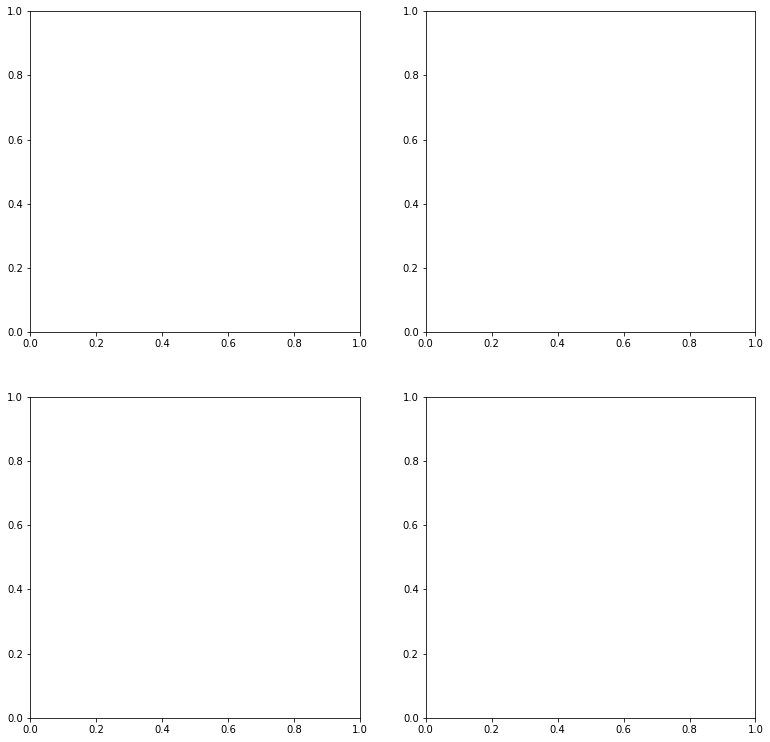

In [20]:
Respiratory = PopulateSetWithECL('<<106048009')
Asthma = PopulateSetWithECL('<<195967001')
COPD = PopulateSetWithECL('<<13645005')
Cardiovascular = PopulateSetWithECL('<<106063007')
Infectious = PopulateSetWithECL('<<40733004')
Cancer = PopulateSetWithECL('<<363346000')
Diabetes = PopulateSetWithECL('<<73211009')
Kidney = PopulateSetWithECL('<<249578005')
Musculoskeletal = PopulateSetWithECL('<<106028002')

#Generate a few Venn Diagrams illustrating overlap with the "Respiratory" category
figure, axes = plt.subplots(2, 2, figsize=(13,13))
plt.style.use('tableau-colorblind10')
venn3([Respiratory,Asthma,COPD],set_labels=('Respiratory','Asthma','COPD'),ax=axes[0][0])
venn3([Respiratory,Cardiovascular,Infectious],set_labels=('Respiratory','Cardiovascular','Infectious'),ax=axes[0][1])
venn3([Respiratory,Cancer,Musculoskeletal],set_labels=('Respiratory','Cancer','Musculoskeletal'),ax=axes[1][0])
venn3([Respiratory,Diabetes,Kidney],set_labels=('Respiratory','Diabetes','Kidney'),ax=axes[1][1])
plt.tight_layout()
#figure.suptitle("Comparison of Overlap between Categories")
plt.savefig("Respiratory.svg",transparent=True)
plt.show()

The approach so far has categoriesed the conditions in the given sequence, such that later conditions matching later categories will be over-riden. Inversely, the labels could be applied only to 'unlabled' episodes, such that episodes are labeled in order of priority and not overridden.

It is also possible to build disjointness into the categories using ECL, if required. For example:

_Respiratory problems excluding Cancer, Musculoskeletal and infectious disorders_ could be specified as:

`<<106048009|Respiratory| minus (<<363346000|Cancer| OR  <<106028002|Musculoskeletal|OR <<40733004|Infectious)`


The approach taken, depends on the analytics use case and wether or not it's acceptable to "double count" episodes. Consider an analysis of the diabetes patients.

Number of Diabetes mellitus episodes : 28825
Number of Type 1 DM episodes : 14648
Number of Type 2 DM episodes : 13215
Number of DM during pregnancy episodes : 1464
Number of Gestational diabetes mellitus episodes : 26
Number of Pre-existing DM in pregnancy episodes : 716
Sum of all the counted episodes : 30069


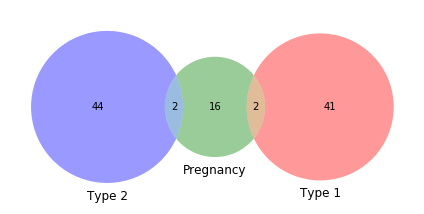

In [16]:
DiabetesEpisodes=codeSet[codeSet["Category"]=='Diabetes mellitus'].copy()
print("Number of Diabetes mellitus episodes : " + str(DiabetesEpisodes.shape[0]))

DiabetesCategories=[
('<<46635009','Type 1 DM'),
('<<44054006','Type 2 DM'),
('<<199223000','DM during pregnancy'),
('<<11687002','Gestational diabetes mellitus'),
('<<609563008','Pre-existing DM in pregnancy')
]
total=0

for d in DiabetesCategories:
    count=DiabetesEpisodes[DiabetesEpisodes["Condition"].isin(PopulateSetWithECL(d[0]))].shape[0]
    print("Number of {0} episodes : {1}".format(d[1],count))
    total+=count

print("Sum of all the counted episodes : {0}".format(total))

T1DM=PopulateSetWithECL('<<46635009')
T2DM=PopulateSetWithECL('<<44054006')
Gestational=PopulateSetWithECL('<<199223000')

venn3([T1DM,Gestational,T2DM],set_labels=('Type 1','Pregnancy','Type 2'))

plt.tight_layout()
plt.savefig("Diabetes.svg",transparent=True)
plt.show()

In [29]:
opioids= [('<34841011000036108','dihydrocodeine'),
('<21480011000036107','hydromorphone'),
('<21821011000036104','codeine'),
('<21705011000036108','pholcodine'),
('<21232011000036101','buprenorphine'),
('<21357011000036109','methadone'),
('<135971000036102','tapentadol'),
('<21258011000036102','fentanyl'),
('<21259011000036105','oxycodone'),
('<34838011000036103','remifentanil'),
('<34836011000036102','alfentanil'),
('<21252011000036100','morphine'),
('<21486011000036105','tramadol'),
('<21901011000036101','dextropropoxyphene'),
('<34839011000036106','pethidine'),
('<1247191000168104','sufentanil')]

for opioid in opioids:
    opioidSet = PopulateSetWithECL(opioid[0])
    filt = codeSet["Medication"].isin(opioidSet)
    codeSet.loc[filt,"Opioid"] = opioid[1]
    
OpioidEpisodes=codeSet[codeSet['Opioid'].notnull()]



In [39]:
print(OpioidEpisodes[['Sex','Medication','Category','Opioid']].head(10))
print(OpioidEpisodes[['Sex','Medication','Category','Opioid']].tail(10))

print(OpioidEpisodes['Opioid'].value_counts())

    Sex         Medication                 Category              Opioid
65    M   7349011000036100  Cardiovascular problems           oxycodone
89    M    789601000168105  Cardiovascular problems           oxycodone
205   F    763001000168101  Cardiovascular problems           oxycodone
219   M   1070441000168107          Other Condition             codeine
247   M   1064391000168109  Cardiovascular problems             codeine
271   M  53819011000036106  Cardiovascular problems             codeine
365   F  40235011000036102  Cardiovascular problems  dextropropoxyphene
561   M   1070991000168109  Cardiovascular problems             codeine
648   F   1048081000168105           Mental illness       buprenorphine
931   M    778581000168103  Cardiovascular problems           oxycodone
       Sex          Medication                 Category              Opioid
499582   F     779571000168107  Cardiovascular problems       buprenorphine
499602   F    1047931000168107  Cardiovascular problems 

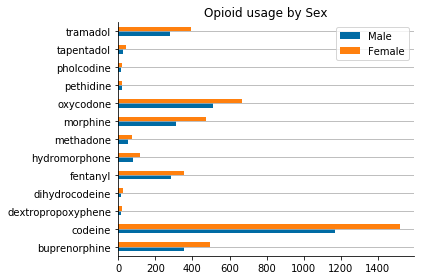

In [14]:
maleOpioids=OpioidEpisodes[OpioidEpisodes["Sex"]=='M']['Opioid'].value_counts().sort_index()
femaleOpioids=OpioidEpisodes[OpioidEpisodes["Sex"]=='F']['Opioid'].value_counts().sort_index()
OpioidIndex=OpioidEpisodes['Opioid'].value_counts().sort_index().index.tolist()

df = pd.DataFrame({'Male': maleOpioids,
                   'Female': femaleOpioids}, 
                   index=OpioidIndex)


plt.style.use('tableau-colorblind10')
ax = df.plot.barh()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.grid(b=None,axis='y')
ax.set_title('Opioid usage by Sex')
plt.tight_layout()

plt.savefig("OpioidUsage.svg",transparent=True)
plt.show()

All the ECL used so far have been simple subsumption queries, yet the language supports so much more expresivity! Concepts in SNOMED CT, are defined with attributes that can also be queried in ECL. AMT even supports numerical queries, such as identifying "All aspirin products with a strength greater than 200mg"

<table border="0">
 <tr>
    <td>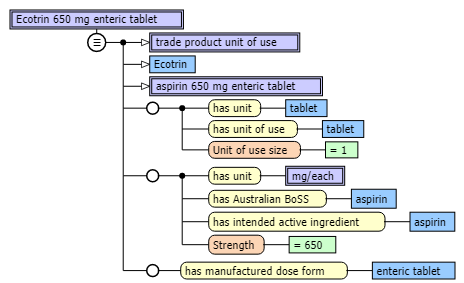</td>
    <td>
        <div style="text-align: left">
        ECL to identify all products with at least 200mg of aspirin, and no other ingredients
        <code>
        <30497011000036103|medicinal product|:
        {
         30364011000036101|has Australian BoSS|=1817011000036100|aspirin|,
         700000111000036105|Strength| >= #200,
         177631000036102|has unit|=700000801000036102|mg/each|
        }
       ,[1..1] 700000081000036101|has intended active ingredient|=ANY
        </code>
        </div>        
   </td>
 </tr>
</table>

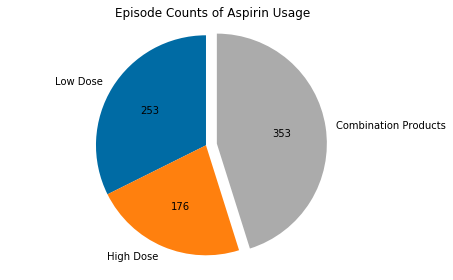

In [17]:
lowDoseAspirinProductsECL= '<30497011000036103:{30364011000036101=1817011000036100,700000111000036105 < #200,177631000036102=700000801000036102},[1..1] 700000081000036101=*'
HighDoseAspirinProductsECL='<30497011000036103:{30364011000036101=1817011000036100,700000111000036105 >= #200,177631000036102=700000801000036102},[1..1] 700000081000036101=*'
CombinationAspirinProductsECL='<21719011000036107:[2..*] 700000081000036101=*'

#Doing something different this time...
#Rather than inplace labeling the dataframe. The ECL Set filters are applied, and the rows are counted.
lowDoseEpisodeCount=codeSet.loc[codeSet["Medication"].isin(PopulateSetWithECL(lowDoseAspirinProductsECL))].shape[0]
HighDoseEpisodesCount=codeSet.loc[codeSet["Medication"].isin(PopulateSetWithECL(HighDoseAspirinProductsECL))].shape[0]
CombinationEpisodesCount=codeSet.loc[codeSet["Medication"].isin(PopulateSetWithECL(CombinationAspirinProductsECL))].shape[0]

#Illustrate the results with a Pie Chart
labels = 'Low Dose', 'High Dose', 'Combination Products'
sizes = [lowDoseEpisodeCount,HighDoseEpisodesCount,CombinationEpisodesCount]
fig, ax = plt.subplots()
ax.pie(sizes, explode=(0, 0, 0.1), labels=labels,
       autopct=lambda p: '{:.0f}'.format((p/100)*sum(sizes)),
        shadow=False, startangle=90)
ax.axis('equal')
ax.set_title('Episode Counts of Aspirin Usage')
plt.tight_layout()
plt.savefig("AspirinUsage.svg",transparent=True)
plt.show()